<a href="https://colab.research.google.com/github/lassmed/Search-engine-and-recommendation-system/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PPP - Advanced Search Engine and Recommendation System for an e-commerce product recommendation**

**Exploratory data analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Data Manipulation
import pandas as pd
import numpy as np

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#NLP for text pre-processing
import nltk
import scipy
import re
from scipy import spatial
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
tokenizer = ToktokTokenizer()

# other libraries
import gensim
from gensim.models import Word2Vec
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# remove warnings
import warnings
warnings.filterwarnings(action='ignore')


In [ ]:
# Read the CSV file into a pandas DataFrame
file_path = '/content/drive/MyDrive/ppp /flipkart_com-ecommerce_sample.csv'
data = pd.read_csv(file_path)

data.head()
data.shape
#data.info()


(20000, 15)

Text(0.5, 1.0, 'Word distribution per bin')

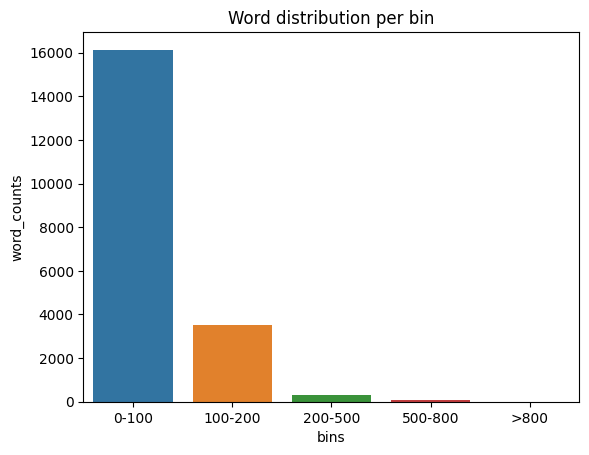

In [ ]:
#add a new column :length of the description
data['length']=data['description'].str.len()
#Add a new column : number of words in the description before text preprocessing
#data['no_of_words']= data.description.apply(lambda x : len(x.split()))
data['no_of_words'] = data['description'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

#word count distribution for description
bins= [0,50,75, np.inf]
data['bins' ]=pd.cut(data.no_of_words, bins=[0,100, 300, 500, 800, np.inf],
labels=['0-100', '100-200', '200-500', '500-800','>800'])

words_distribution = data.groupby('bins').size().reset_index().rename(columns={0: 'word_counts'})
sns.barplot (x='bins', y='word_counts', data=words_distribution).set_title("Word distribution per bin")


**Data Pre-processing**

In [ ]:
# Number of missing values in each column
missing = pd.DataFrame(data.isnull().sum()).rename (columns = {0:'missing' })
# Create a percentage of missing values
missing['percent'] = missing [ 'missing']/ len(data)
# sorting the values in desending order to see highest count on the top
missing.sort_values('percent', ascending = False)

,missing,percent
brand,5864,0.29320
retail_price,78,0.00390
discounted_price,78,0.00390
product_specifications,14,0.00070
image,3,0.00015
bins,2,0.00010
length,2,0.00010
description,2,0.00010
product_rating,0,0.00000
no_of_words,0,0.00000


**Text Pre-processing**

In [ ]:
# Remove punctuation
data['description'] = data['description'].str.replace(r'[^\w\d\s]',' ')
# Replace whitespace between terms with a single space
data['description'] = data['description'].str.replace(r'\s+',' ')
# Remove leading and trailing whitespace
data['description'] = data['description'].str.replace(r'^\s+|\s+?$', '')
# converting to lower case
data['description'] = data['description'].str.lower()
data['description'].head()


0    key features of alisha solid women s cycling s...
1    fabhomedecor fabric double sofa bed finish col...
2    key features of aw bellies sandals wedges heel...
3    key features of alisha solid women s cycling s...
4    specifications of sicons all purpose arnica do...
Name: description, dtype: object

In [ ]:
#Removing Stop words
import nltk
nltk.download('stopwords')
stop= stopwords.words('english')
pattern= r'\b(?:{})\b'.format('|'.join(stop))
data['description'] = data['description'].str.replace(pattern, '')

#Removing single caharacters
data['description'] = data['description'].str.replace(r'\s+',' ')
#data['description'] = data['description'].apply(lambda x: " ".join(x for x in x.split() if len(x)>1))
data['description'] = data['description'].apply(lambda x: " ".join([w for w in str(x).split() if len(w) > 1]))

# Removing domain related stop words from description
specific_stop_words= [ "rs","flipkart", "buy", "com", "free","day", "cash", "replacement", "guarantee", "genuine", "key", "feature", "delivery", "products", "product", "shipping", "online", "india","shop"]
data['description'] = data['description'].apply(lambda x: " ".join(x for x in x.split() if x not in specific_stop_words))

data['description'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    features alisha solid women cycling shorts cot...
1    fabhomedecor fabric double sofa bed finish col...
2    features aw bellies sandals wedges heel casual...
3    features alisha solid women cycling shorts cot...
4    specifications sicons purpose arnica dog shamp...
Name: description, dtype: object

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


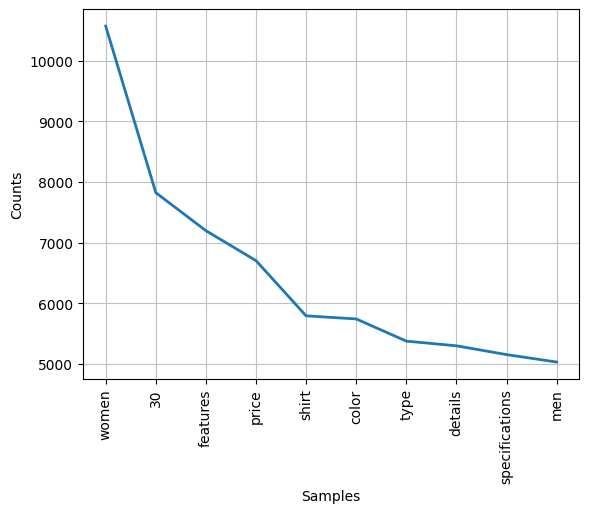

[('women', 10574), ('30', 7826), ('features', 7199), ('price', 6705), ('shirt', 5794), ('color', 5743), ('type', 5377), ('details', 5300), ('specifications', 5155), ('men', 5032)]


In [ ]:
import nltk
nltk.download('punkt')
#Top frequent words after removing domain related stop words
a = data['description'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
word_dist.plot(10, cumulative=False)
print(word_dist.most_common(10))

**Model Building**

Content-based Recommendation system

1.   Élément de liste
2.   Élément de liste



In [ ]:
#text cleaning
data['description'] = data['description'].fillna('')
#define the vectorizer
T_vec = TfidfVectorizer(stop_words='english' )
# get the vectors
T_vec_matrix = T_vec.fit_transform(data['description'])
#shape
T_vec_matrix.shape

(20000, 26163)

In [ ]:
# Reversing the map of indices and product
product_index = pd.Series(data.index, index=data['product_name']).drop_duplicates()
product_index

product_name
Alisha Solid Women's Cycling Shorts            0
FabHomeDecor Fabric Double Sofa Bed            1
AW Bellies                                     2
Alisha Solid Women's Cycling Shorts            3
Sicons All Purpose Arnica Dog Shampoo          4
                                           ...  
WallDesign Small Vinyl Sticker             19995
Wallmantra Large Vinyl Stickers Sticker    19996
Elite Collection Medium Acrylic Sticker    19997
Elite Collection Medium Acrylic Sticker    19998
Elite Collection Medium Acrylic Sticker    19999
Length: 20000, dtype: int64

In [ ]:
# Function that takes in product title as input and outputs the most similar product
def predict_products(text):
    # Check if the product name is present in the index dictionary
    if text.strip() in product_index:
        # Get the index of the product
        index = product_index[text.strip()]
        # Obtain the pairwise similarity scores
        score_matrix = linear_kernel(T_vec_matrix[index], T_vec_matrix)
        matching_sc = list(enumerate(score_matrix[0]))
        # Sort the products based on the similarity scores
        matching_sc = sorted(matching_sc, key=lambda x: x[1], reverse=True)
        # Getting the scores of the 10 most similar products
        matching_sc = matching_sc[1:10]
        # Getting the product indices
        product_indices = [i[0] for i in matching_sc]
        # Show the similar products
        return data['product_name'].iloc[product_indices]
    else:
        return None

# Prompt the user for a product name and get the recommended products
product_name = input("Enter a product name: ")
recommended_products = predict_products(product_name)

if recommended_products is not None:
    print("Similar products:")
    print("\n".join(recommended_products))
else:
    print("Product not found in the dataset.")


Enter a product name: Alisha Solid Women's Cycling Shorts
Similar products:
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Mynte Solid Women's Cycling Shorts, Gym Shorts, Swim Shorts
Mynte Solid Women's Cycling Shorts, Gym Shorts, Swim Shorts
Mynte Solid Women's Cycling Shorts, Gym Shorts, Swim Shorts




```
# Ce texte est au format code
```

Product Search Engine

In [ ]:
#Creating list containing description of each product as sublist
fin=[ ]
for i in range(len(data['description'])):
 temp=[]
 temp.append(data['description' ][i])
 fin = fin + temp

data1 = data[['product_name', 'description' ] ]

In [ ]:
#import the word2vec
from gensim.models import KeyedVectors
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

[=================================================-] 99.7% 1657.4/1662.8MB downloaded


In [ ]:

#Preprocessing
def remove_stopwords(text, is_lower_case=False):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Obtain the embeddings, lets use “300”
def get_embedding(word) :
 if word in model.key_to_index:
  return model[word]
 else:
  return np.zeros(300)

# Obtaining the average vector for all the documents
out_dict = {}
for sen in fin:
    processed_text = remove_stopwords(sen)
    average_vector = np.mean(np.array([get_embedding(x) for x in nltk.word_tokenize(processed_text)]), axis=0)
    out_dict[sen] = average_vector


# Get the similarity between the query and documents



def get_sim(query_embedding, average_vector_doc):
    sim = 1 - scipy.spatial.distance.cosine(query_embedding, average_vector_doc)
    return sim


# Rank all the documents based on the similarity
def Ranked_documents(query):
    query_words = np.mean(
        np.array([get_embedding(x) for x in nltk.word_tokenize(remove_stopwords(query.lower()))], dtype=float),
        axis=0
    )
    rank = []
    for k, v in out_dict.items():
        score = get_sim(query_words, v)
        if score < 1:
            rank.append((k, score))
    rank = sorted(rank, key=lambda t: t[1], reverse=True)
    ranked_rows = []
    for desc, score in rank:
        row = data1[data1['description'] == desc].copy()
        row['score'] = score
        ranked_rows.append(row)
    ranked_df = pd.concat(ranked_rows, ignore_index=True)
    ranked_df = ranked_df.sort_values(by='score', ascending=False)
    print('Ranked Documents:')
    return ranked_df[['product_name', 'description', 'score']]


In [ ]:
# Call the IR function with a query
query=input("What would you like to search: ")
Ranked_documents(query)

What would you like to search: dress
Ranked Documents:


,product_name,description,score
0,Mykraft Girl's A-line Dress,mykraft girl line dress price 964 blue lace st...,0.812852
1,ABHIRA Girl's A-line Dress,abhira girl line dress price 699 give trendy b...,0.799850
2,ABHIRA Girl's A-line Dress,abhira girl line dress price 499 give trendy b...,0.786744
3,Meish Women's Sheath Dress,meish women sheath dress price 764 bring diva ...,0.778662
4,Cutecumber Girl's A-line Dress,cutecumber girl line dress price 995 printed d...,0.768980
...,...,...,...
19968,Setu Infocom 4 Port Fxo Gateway,setu infocom port fxo gateway 18000 30,-0.021837
19969,Digisol DG-BG4100N,digisol dg bg4100n 1470 30,-0.023152
19970,Rega IT Compaq Presario V3500 V3500CTO 6 Cell ...,rega compaq presario v3500 v3500cto cell cell ...,-0.023499
19971,Retina Steering Mobile Holder,retina steering mobile holder 145 30,-0.037296


# Advanced Search Engine Using PyTerrier and Sentence-BERT

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
%matplotlib inline
import nltk
nltk.download('punkt' )
nltk.download('wordnet' )
nltk.download('stopwords' )
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english' ))
exclude = set(string.punctuation)
import string

!pip install python-terrier
import pyterrier as pt
if not pt.started():
 pt.init()
!pip install -U sentence-transformers

!pip install neuspell
!pip install -e neuspell/
!git clone https://github.com/neuspell/neuspell; cd neuspell
import os
os.chdir("/content/neuspell" )

!pip install -r /content/neuspell/extras-requirements.txt
!python -m spacy download en_core_web_sm

#Unzipping the multi-linguistic packages
#!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
#!unzip *.zip

#importing neuspell
from neuspell import BertChecker
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.0 MB/s eta 0:00:00
  Preparing met

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=e4755ef2cf3f7258ab869b9408ce2fdf16719248ab355e989acd0e034affd0c1
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')
file_path = '/content/drive/MyDrive/ppp/flipkart_com-ecommerce_sample.csv'
df = pd.read_csv(file_path)
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


Data Preprocessing

In [ ]:
#make the 'category_tree' column a simple list.
df[ 'product_category_tree' ]=df['product_category_tree'].map(lambda x:x.strip('[]'))
df[ 'product_category_tree' ]=df['product_category_tree'].map(lambda x:x.strip('"'))
df[ 'product_category_tree' ]=df['product_category_tree'].map(lambda x:x.split('>>'))
#drop unwanted columns
df.drop(['crawl_timestamp','product_url','image',"retail_price" ,"discounted_price","is_FK_Advantage_product", "product_rating", "overall_rating", "product_specifications"],axis=1, inplace=True)
#drop duplicate products
uniq_prod=df.copy()
uniq_prod.drop_duplicates(subset ="product_name", keep = "first", inplace =True)
#Remove stop words and punctuations and then perform tokenization and lemmatization.
def filter_keywords(doc):
 doc=doc. lower( )
 stop_free = " ".join([i for i in doc.split() if i not in stop_words])
 punc_free = "".join(ch for ch in stop_free if ch not in exclude)
 word_tokens = word_tokenize(punc_free)
 filtered_sentence = [(lem.lemmatize(w, "v")) for w in word_tokens]
 return filtered_sentence
#Apply the filter_keywords function to selected columns to obtain the keywords for each column.
uniq_prod['product'] = uniq_prod[ 'product_name'].apply(filter_keywords)
uniq_prod['description'] = uniq_prod['description'].astype("str").apply(filter_keywords)
uniq_prod['brand'] = uniq_prod['brand'].astype("str").apply(filter_keywords )
#Combine all the keywords for each product.
uniq_prod[ "keywords" ]=uniq_prod['product' ]+uniq_prod['brand' ]+ df[ 'product_category_tree']+uniq_prod['description' ]
uniq_prod["keywords"] = uniq_prod["keywords"].apply(lambda x: ' '.join(x))
#Creating a'docno' column, which gives recommendations.
uniq_prod['docno' ]=uniq_prod['product_name' ]
#Drop unwanted columns.
uniq_prod.drop(['product','brand', 'pid', 'product_name' ],axis=1, inplace=True)

uniq_prod.head()

,uniq_id,product_category_tree,description,keywords,docno
0,c2d766ca982eca8304150849735ffef9,"[Clothing , Women's Clothing , Lingerie, Sle...","[key, feature, alisha, solid, womens, cycle, s...",alisha solid womens cycle short alisha Clothin...,Alisha Solid Women's Cycling Shorts
1,7f7036a6d550aaa89d34c77bd39a5e48,"[Furniture , Living Room Furniture , Sofa Be...","[fabhomedecor, fabric, double, sofa, bed, fini...",fabhomedecor fabric double sofa bed fabhomedec...,FabHomeDecor Fabric Double Sofa Bed
2,f449ec65dcbc041b6ae5e6a32717d01b,"[Footwear , Women's Footwear , Ballerinas , ...","[key, feature, aw, belly, sandals, wedge, heel...",aw belly aw Footwear Women's Footwear Ball...,AW Bellies
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,"[Pet Supplies , Grooming , Skin & Coat Care ...","[specifications, sicons, purpose, arnica, dog,...",sicons purpose arnica dog shampoo sicons Pet S...,Sicons All Purpose Arnica Dog Shampoo
5,c2a17313954882c1dba461863e98adf2,[Eternal Gandhi Super Series Crystal Paper Wei...,"[key, feature, eternal, gandhi, super, series,...",eternal gandhi super series crystal paper weig...,Eternal Gandhi Super Series Crystal Paper Weig...


Building the Search Engine

In [ ]:


from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from neuspell import BertChecker
#use the DFIndexer object to create the index for keywords.
!rm -rf /content/pd_index
!rm -rf /content/iter_index_porter
pd_indexer = pt.DFIndexer("/content/pd_index")
indexref = pd_indexer.index(uniq_prod["keywords"], uniq_prod["docno"])
 #implementing the NeuSpell spell checker on the user query and save it to an object.
#spellcheck= BertChecker()
#spellcheck.from_pretrained('bert-base-uncased')
#spellcheck.from_pretrained(ckpt_path=f"/content/multi_cased_L-12_H-768" )
#spellcheck.from_pretrained(ckpt_path='bertscrnn-probwordnoise')
# "<folder where the model is saved>"


X=input("Search Engine:")
#query=spellcheck.correct(X)
query=X
print (query )
#Perform ranking and retrieval using PyTerrier and Sentence-BERT.
prod_ret = pt.BatchRetrieve(indexref, wmodel='TF_IDF',properties={'termpipelines': 'Stopwords' })
pr=prod_ret.compile()
output=pr.search(query)
docno=list(output[ 'docno' ])
transform=model.encode(docno)
#Create embeddings and re-ranking using PyTerrier and cosine similarity.
embedding={ }
for i,product in enumerate(docno):
 embedding[ product ]=transform[i]
q_embedding=model.encode(query).reshape(1, -1)
l=[]
for product in embedding.keys():
 score = cosine_similarity(q_embedding, embedding[product].reshape(1,-1))[0] [0]
 l.append([product, score] )
 output2=pd.DataFrame(l,columns=['product_name', 'score' ])

output2.sort_values(by='score',ascending=False).head(10)

Search Engine:AW Bellies
AW Bellies
Applying 8 rules


,product_name,score
0,AW Bellies,1.000000
26,Oggo Deo Bellies,0.874236
30,Treppe Bellies,0.861926
6,Ladela Bellies,0.858016
34,Kanvas Bellies,0.840706
20,BrandTrendz Bellies,0.837392
23,SCANTIA Bellies,0.829229
14,Bonzer Bellies,0.823341
19,Footash Bellies,0.783452
12,Mobiroy Bellies,0.751998


Multilingual Search Engine Using Deep Text Search

In [ ]:

!pip install DeepTextSearch


# importing nltk
import nltk
nltk.download('punkt' )
nltk.download('averaged_perceptron_tagger' )
nltk.download('maxent_ne_chunker' )
nltk.download( 'words' )
nltk.download( 'wordnet' )
#import DeepTextSearch
from DeepTextSearch import TextEmbedder, TextSearch,LoadData
from nltk.corpus import wordnet
from neuspell import BertChecker



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for DeepTextSearch: filename=DeepTextSearch-0.3-py3-none-any.whl size=5960 sha256=d73df9a1c91a7950b9ef0d0596a6e8f15ab4d403f7cd206673408bf79eb53a52
  Stored in directory: /root/.cache/pip/wheels/42/d0/2d/8cc561b3ec64be99cebaf3e296c11c7a2d2bdca21bf8e8bd6c
Successfully built DeepTextSearch


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#use BERTChecker for spell checking. It also supports multiple languages.
#spellcheck = BertChecker()
#spellcheck.from_pretrained(ckpt_path=f"/content/multi_cased_L-12_H-768_A12")
# "<folder where the model is saved>"

#input the query and check how its works.
X=input("Enter Product Name:")
#y=spellcheck.correct(X)
y=X
print(y)

#use POS tagging to select relevant words from the given query.

#function to get the POS tag
def preprocess(sent):
 sent = nltk.word_tokenize(sent)
 sent = nltk.pos_tag(sent)
 return sent
sent = preprocess(y)
l=[]
for i in sent:
 if i[1]=='NNS' or i[1]=='NN':
  l.append(i[0])
print(l)

#use query expansion to get synonyms of words, so that we can get more relevant recommendations.
query=""

for i in l:
 query+=i
 synset = wordnet.synsets(i)
 query+="_"+synset[0].lemmas()[0].name()+" "
print (query)

#We created this dictionary to display the product names as per the recommendations given in the description.
#importing the data
df=pd.read_csv("/content/drive/MyDrive/ppp/flipkart_com-ecommerce_sample.csv")
df1=df.set_index("description", inplace = False)
df2=df1.to_dict()
dict1=df2[ 'product_name']

#Embed the data in a pickle file as the library requires it to be in that format.
data = LoadData().from_csv("/content/drive/MyDrive/ppp/flipkart_com-ecommerce_sample.csv")
TextEmbedder().embed(corpus_list=data)
corpus_embedding = TextEmbedder().load_embedding()

#Search the ten most relevant products based on the query.
n=10
t=TextSearch().find_similar(query_text=query,top_n=n)
for i in range(n):
 t[i][ 'text' ]=dict1[t[i]['text']]
 print(t[i])


Enter Product Name:AW Bellies
AW Bellies
['Bellies']
Bellies_abdomen 
Input the text Column Name Please ? : description


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Embedding data Saved Successfully!
['corpus_list_data.pickle', 'corpus_embeddings_data.pickle']
Embedding data Loaded Successfully!
['corpus_list_data.pickle', 'corpus_embeddings_data.pickle']
{'index': 532, 'text': 'Bonzer Bellies', 'score': 0.37488145}
{'index': 17660, 'text': 'tryfeet Open Toe Blue Bellies', 'score': 0.3632689}
{'index': 15950, 'text': 'Bow! Wow!! ROUNDREDLALBIG L Pet Bed', 'score': 0.36098173}
{'index': 10513, 'text': 'My Look KBSB-05-Beige-41 Bellies', 'score': 0.3576535}
{'index': 16952, 'text': 'Bajya Cotton Bath Towel', 'score': 0.35402012}
{'index': 10, 'text': 'Ladela Bellies', 'score': 0.35267887}
{'index': 3378, 'text': 'Footash Bellies', 'score': 0.35087892}
{'index': 3020, 'text': 'Bootwale Bellies', 'score': 0.35072365}
{'index': 15870, 'text': 'Bow! Wow!! ROUNDBEDLALREDMED M Pet Bed', 'score': 0.35003185}
{'index': 3052, 'text': 'Bootwale Bellies', 'score': 0.34381047}


In [ ]:
# import library and data
from DeepTextSearch import LoadData
data1 = LoadData().from_csv("/content/drive/MyDrive/ppp/flipkart_com-ecommerce_sample.csv")
TextEmbedder().embed(corpus_list=data1)
corpus_embedding = TextEmbedder().load_embedding()

Input the text Column Name Please ? : description
Embedding data allready present, Do you want Embed & Save Again? Enter yes or no
yes


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Embedding data Saved Successfully Again!
['corpus_list_data.pickle', 'corpus_embeddings_data.pickle']
Embedding data Loaded Successfully!
['corpus_list_data.pickle', 'corpus_embeddings_data.pickle']


In [ ]:
y1=input("Search Engine:")
TextSearch().find_similar(query_text=y1,top_n=10)

Search Engine:قميص


[{'index': 16718,
  'text': "Jovial Mart Store Men's Solid Formal Shirt (Pack of 2)\n                         Price: Rs. 599\n\t\t\t\t\n\t\t\tShow Off Your Love For Smart Dressing As You Wear This Formal Shirt From The House Of Jovial Mart. Fashioned Using The Ultimate Material For Comfort- Cotton, This Shirt Will Keep You At Ease.\nShow Off Your Love For Smart Dressing As You Wear This Formal Shirt From The House Of Jovial Mart. Fashioned Using The Ultimate Material For Comfort- Cotton, This Shirt Will Keep You At Ease.",
  'score': 0.4824113},
 {'index': 16729,
  'text': "Jovial Mart Store Men's Solid Formal Shirt (Pack of 2)\n                         Price: Rs. 599\n\t\t\t\t\n\t\t\tShow Off Your Love For Smart Dressing As You Wear This Formal Shirt From The House Of Jovial Mart. Fashioned Using The Ultimate Material For Comfort- Cotton, This Shirt Will Keep You At Ease.\nShow Off Your Love For Smart Dressing As You Wear This Formal Shirt From The House Of Jovial Mart. Fashioned Usin